## https://www.kaggle.com/c/ieee-fraud-detection

# IEEE-CIS Fraud Detection
## Can you detect fraud from customer transactions?

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

**Categorical Features - Transaction**
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

You can read more about the data from this post by the competition host.

**Files**

train_{transaction, identity}.csv - the training set
test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
sample_submission.csv - a sample submission file in the correct format

In [1]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# Data Exploring

In [3]:
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv')

In [4]:
train_trans = pd.read_csv('ieee-fraud-detection/train_transaction.csv')

In [48]:
test_id = pd.read_csv('ieee-fraud-detection/test_identity.csv')

In [49]:
test_trans = pd.read_csv('ieee-fraud-detection/test_transaction.csv')

In [6]:
df = train_trans.merge(train_id, how='left', on='TransactionID')
df_test = test_trans.merge(test_id, how='left', on='TransactionID')
del train_trans, train_id, test_trains, test_id

In [2963]:
df.shape

(590540, 434)

In [2505]:
def change_dtype(df,type_to_change_dict):
    for feature in type_to_change_dict:
        df[feature] = df[feature].astype(type_to_change_dict[feature])

In [2756]:
#reduce memory use
# float32, int32 is enough to hold these data and to get sum and mean (checked)
for col in df.columns:
    if df[col].dtype == np.float64:
        change_dtype(df, {col:np.float32})
    elif df[col].dtype == np.int64:
        change_dtype(df, {col:np.int32})

for col in df_test.columns:
    if df_test[col].dtype == np.float64:
        change_dtype(df_test, {col:np.float32})
    elif df_test[col].dtype == np.int64:
        change_dtype(df_test, {col:np.int32})
        
# only binary values
df['isFraud']=df['isFraud'].astype(np.int8)

## Let's take a look at the data

In [2321]:
list(df.columns)[:4]

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt']

In [2735]:
# Function to show data information
def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['missing'] = df.isnull().sum().values    
    summary['uniques'] = df.nunique().values
    summary['min'] = [df[col].min() if df[col].dtype !='O' else 'nan' for col in df.columns ]
    summary['max'] = [df[col].max() if df[col].dtype !='O' else 'nan' for col in df.columns ]
    summary['top'] = [df[col].value_counts().index[0] for col in df.columns]
    summary['freq'] = [df[col].value_counts().values[0] for col in df.columns]
    summary.set_index('Name', inplace = True)
    summary = summary.rename_axis(None)
    return summary.transpose()

In [2903]:
# Plot Functions

# Function to plot the statistics for categorical data
def bar_plot(df, feature, target = 'isFraud', nan_to_null = True, others_threshold = 5000, 
             target_plots =True, xtick_rotate = False, reduced = False):
    total_num = len(df)
    if feature != target:
        df_trans = df[[target, feature, 'TransactionAmt']].copy()
        if nan_to_null:
            df_trans[[feature]] = df_trans[[feature]].fillna('null')

        df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
                    [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
                     , feature] = "Others"

        tmp = pd.crosstab(df_trans[feature], df_trans[target], normalize='index') * 100
        tmp.reset_index(inplace = True)
        tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    #    plot_order = list(df_trans[feature].unique())
        plot_order = df_trans[feature].value_counts().keys()

    #     perc_amt = (df_trans.groupby([target,feature])['TransactionAmt'].sum() / total_amt * 100).unstack(target)
    #     perc_amt = perc_amt.reset_index()
    #     perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
        groupby_amt = df_trans.groupby([feature, target])['TransactionAmt'].sum()

        tmp_amt = (groupby_amt).unstack(target) 
        tmp_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
        perc_amt = tmp_amt.div(tmp_amt.sum(axis=1), axis=0) *100
        perc_amt.reset_index(inplace = True)
        tmp_amt.reset_index(inplace = True)
        tmp_amt['total'] = tmp_amt['NoFraud']+tmp_amt['Fraud']
        total_amt = tmp_amt['total'].sum()

        tmp_amt_expanded = pd.DataFrame(groupby_amt).reset_index()
        
    
    elif feature == target:
        target_plots = False
        df_trans = df[[feature, 'TransactionAmt']].copy()
        groupby_amt = df_trans.groupby([feature])['TransactionAmt'].sum()
        tmp_amt = pd.DataFrame(groupby_amt).reset_index()
        tmp_amt.rename(columns={'TransactionAmt':'total'}, inplace = True)
        total_amt = tmp_amt['total'].sum()
        plot_order = df_trans[feature].value_counts().keys()        
                
    plt.figure(figsize=(14,13))
    if target_plots & (not reduced):
        title_y = 0.92
    elif reduced:
#        title_y = 1.02 #if use tight layout
        title_y = 0.94
    else:
        title_y = 0.95 #default 0.98
    plt.suptitle(f'{feature} Distributions', fontsize=22, y=title_y)
        
    plt.subplot(321)
    g = sns.countplot(x=feature, data=df_trans, order = plot_order)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"Frequency", fontsize=19)
    g.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")
    g.set_ylabel("Count", fontsize=17)
#     if feature == target:
#         g.set_ylim(0,total_num *1.1)
#     else:
#         g.set_ylim(0,550000 )

    for i, p in enumerate(g.patches):
        height = p.get_height()
        if i == 0:
            max_height = height   #bars are in descending order
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_num*100),
                ha="center", fontsize=14)
    g.set_ylim(0, max_height *1.1 )
    
    if reduced:
        g_pt = g.twinx()
        g_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g_pt.set_ylabel("% of Fraud (Counts)", fontsize=16)

    if (target_plots) & (not reduced):
        plt.subplot(322)
        g2 = sns.countplot(x=feature, hue=target, data=df_trans, order = plot_order)

        g2_pt = g2.twinx()
        g2_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g2_pt.set_ylabel("% of Fraud (Counts)", fontsize=16)

        g2.set_title(f"Frequency by Target({target})", fontsize=19)
        g2.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g2.set_xticklabels(g2.get_xticklabels(), rotation=30, ha="right")
        g2.set_ylabel("Count", fontsize=17)

    if (target_plots) & (not reduced):
        plt.subplot(323)
    elif (not target_plots) | reduced:
        plt.subplot(322)
    sns.set_color_codes("pastel")
    g4 = sns.barplot(x=feature, y='total', data=tmp_amt , order = plot_order )
    g4.set_title(f"Transaction Amount", fontsize=20)
    g4.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g4.set_xticklabels(g4.get_xticklabels(), rotation=30, ha="right")
    g4.set_ylabel("Transaction Amt $", fontsize=17)
    
    heights = []
    for i, p in enumerate(g4.patches):
        height = p.get_height()
        heights.append(height)
        g4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt*100),
            ha="center", fontsize=14)
    g4.set_ylim(0, max(heights) * 1.1 )
    
    if reduced:
        g4_pt = g4.twinx()
        g4_pt = sns.pointplot(x=feature, y='Fraud', data=perc_amt, order=plot_order,
                           color='black', legend=False )
        g4_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)
    
    
    if target_plots & (not reduced):
        plt.subplot(324)
        sns.set_color_codes("muted")
        g4_hue = sns.barplot(x=feature, y='TransactionAmt', data=tmp_amt_expanded , hue = target , order = plot_order)
        g4_hue.set_title(f"Transaction Amount by Target", fontsize=20)
        g4_hue.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g4_hue.set_xticklabels(g4_hue.get_xticklabels(), rotation=30, ha="right")
        g4_hue.set_ylabel("Transaction Amt $", fontsize=17)    
        
        g4_pt = g4_hue.twinx()
        g4_pt = sns.pointplot(x=feature, y='Fraud', data=perc_amt, order=plot_order,
                           color='black', legend=False )
        g4_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)


        plt.subplot(313)
        g3 = sns.boxenplot(x=feature, y='TransactionAmt', hue=target, 
                      data=df_trans[df_trans['TransactionAmt'] <= 2000] , order = plot_order )
        g3.set_title(f"Transaction Amount Distribution", fontsize=20)
        g3.set_xlabel(f"{feature} Values", fontsize=17)
#         if xtick_rotate:
#             g3.set_xticklabels(g3.get_xticklabels(), rotation=30,ha="right")
        g3.set_ylabel("Transaction Amt $", fontsize=17)


#        plt.tight_layout()
    if reduced:
        plt.subplots_adjust(wspace = 0.25)
    else:
        plt.subplots_adjust(hspace = 0.6, top = 0.85)
    plt.show()


# Function to plot Histograms for float valued features
def dist_plot(df, feature, target = 'isFraud', fill_nan = False ,bin_num = 30 , df_test=pd.DataFrame()):
    plt.figure(figsize=(14,8))
    plt.suptitle(f'{feature} Distributions', fontsize=22)
    TransAmt = (feature == 'TransactionAmt')
    if len(df_test) == 0:
        if TransAmt:
            df_trans = df[[target, 'TransactionAmt']].copy()
        else:
            df_trans = df[[target, feature, 'TransactionAmt']].copy()
        if fill_nan:
            df_trans[feature].fillna(df_trans[feature].mean(), inplace = True)
            df_NoFraud = df_trans[df_trans[target] == 0]
            df_Fraud = df_trans[df_trans[target] == 1]
        else:
            df_NoFraud = df_trans[(df_trans[target] == 0) & (df_trans[feature].notna())]
            df_Fraud = df_trans[(df_trans[target] == 1) & (df_trans[feature].notna())]

        plt.subplot(211)


        bin_num = bin_num

        g = sns.distplot(df_NoFraud[feature], bins=bin_num, kde=False, label='NoFraud')
        height = []
        x_values = []
        bin_edges = []
        for i, p in enumerate(g.patches):
            if i == 0:
                bin_edges.append(p.get_x())
            height.append(p.get_height()) 
            x_values.append(p.get_x()+p.get_width()/2.)
            bin_edges.append(p.get_x()+p.get_width())
        g = sns.distplot(df_Fraud[feature], bins=bin_num, kde=False, label='Fraud')

        height_f = []
        for p in g.patches[bin_num:]:
            height_f.append(p.get_height())
        fraud_perc = np.array(height_f)/(np.array(height_f)+np.array(height)) *100


        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency by Target", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)

        df_f_perc =  pd.DataFrame({feature:x_values ,'Fraud': fraud_perc})

        g_pt = g.twinx()
        g_pt = sns.distplot(df_f_perc[feature], hist=True, kde = False, rug=False, bins = bin_edges,\
                hist_kws={'weights': df_f_perc['Fraud'],"histtype": "step","linewidth": 3 ,\
                          'color':'k'}, label='% of Fraud each bin')
        g_pt.set_ylabel("% of Fraud (counts)", fontsize=16)
        g_pt.legend()

        if not TransAmt:
            plt.subplot(212)

            g2 = sns.distplot(df_NoFraud[feature], bins=bin_num, kde=False,\
                              label='NoFraud',hist_kws={'weights': df_NoFraud['TransactionAmt']})
            height = []
            for i, p in enumerate(g2.patches):
                height.append(p.get_height())

            g2 = sns.distplot(df_Fraud[feature], bins=bin_num, kde=False,\
                              label='Fraud',hist_kws={'weights': df_Fraud['TransactionAmt']})
            height_f = []
            for p in g2.patches[bin_num:]:
                height_f.append(p.get_height())
            fraud_perc = np.array(height_f)/(np.array(height_f)+np.array(height)) *100

            g2.legend(loc='upper left')
            g2.set_title(f"{feature} Transaction Amount by Target", fontsize=20)
            g2.set_xlabel(f"{feature} Values", fontsize=18)
            g2.set_ylabel("TransAmt $ by bin", fontsize=18)

            df_f_perc =  pd.DataFrame({feature:x_values ,'Fraud': fraud_perc})

            g2_pt = g2.twinx()
            g2_pt = sns.distplot(df_f_perc[feature], hist=True, kde = False, rug=False, bins = bin_edges,\
                    hist_kws={'weights': df_f_perc['Fraud'],"histtype": "step","linewidth": 3 ,\
                              'color':'k'},  label='% of Fraud each bin')
            g2_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)
            g2_pt.legend()

        plt.subplots_adjust(hspace = 0.6, top = 0.85)
        plt.show()

        
    elif len(df_test)>0:
        if TransAmt:
            df_trans = df[['TransactionAmt']].copy()
            df_test = df_test[['TransactionAmt']].copy()
        else:
            df_trans = df[[ feature, 'TransactionAmt']].copy()
            df_test = df_test[[ feature, 'TransactionAmt']].copy()
        if fill_nan:
            df_trans[[feature]].fillna(df_trans.mean(), inplace = True)
            df_test[[feature]].fillna(df_trans.mean(), inplace = True)
            
        plt.subplot(211)

        bin_num = 30

        g = sns.distplot(df_trans[feature], bins=bin_num, kde=False, label='train')
        bin_width = next(iter(g.patches)).get_width()
        bin_arr = np.arange(df_test[feature].min(), df_test[feature].max(), bin_width)
        g = sns.distplot(df_test[feature], bins=bin_arr, kde=False, label='test')
      
        
        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)


        if not TransAmt:
            plt.subplot(212)

            g2 = sns.distplot(df_trans[feature], bins=bin_num, kde=False,\
                              label='train',hist_kws={'weights': df_trans['TransactionAmt']})
            g2 = sns.distplot(df_test[feature], bins=bin_arr, kde=False,\
                              label='test',hist_kws={'weights': df_test['TransactionAmt']})

            g2.legend(loc='upper left')
            g2.set_title(f"{feature} Transaction Amount", fontsize=20)
            g2.set_xlabel(f"{feature} Values", fontsize=18)
            g2.set_ylabel("TransAmt $ by bin", fontsize=18)

        plt.subplots_adjust(hspace = 0.6, top = 0.85)
#         plt.tight_layout()
        plt.show()

In [2548]:
summary_table(df[list(df.columns)[:4]])

TransactionID isFraud TransactionDT TransactionAmt
dtypes          int32    int8         int32        float32
missing             0       0             0              0
uniques        590540       2        573349           8195
min         2.987e+06       0         86400       0.250977
max       3.57754e+06       1   1.58111e+07          31936
top       3.14778e+06       0   9.47482e+06             59
freq                1  569877             8          30589

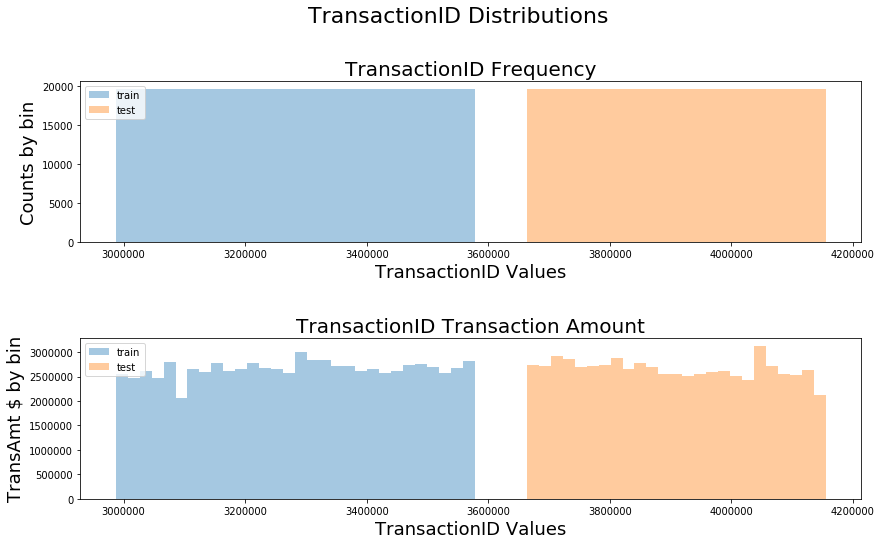

In [2470]:
dist_plot(df, 'TransactionID',df_test = df_test)

- TransactionID is uniformly generated.

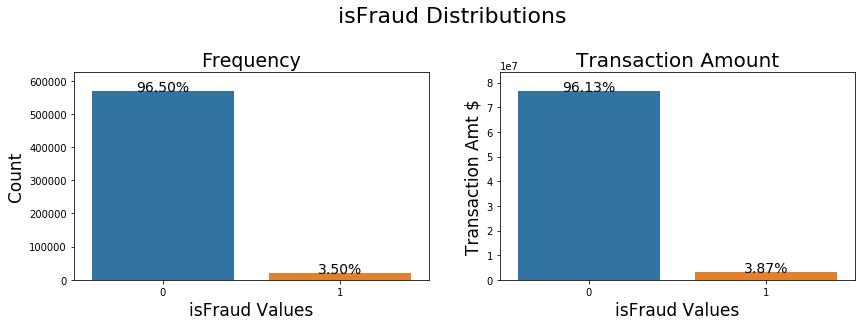

In [2676]:
bar_plot(df, 'isFraud', target_plots=False)

- Fraud data consists only 3.5% in counts, 3.87% in TransAmt
- Very imbalanced

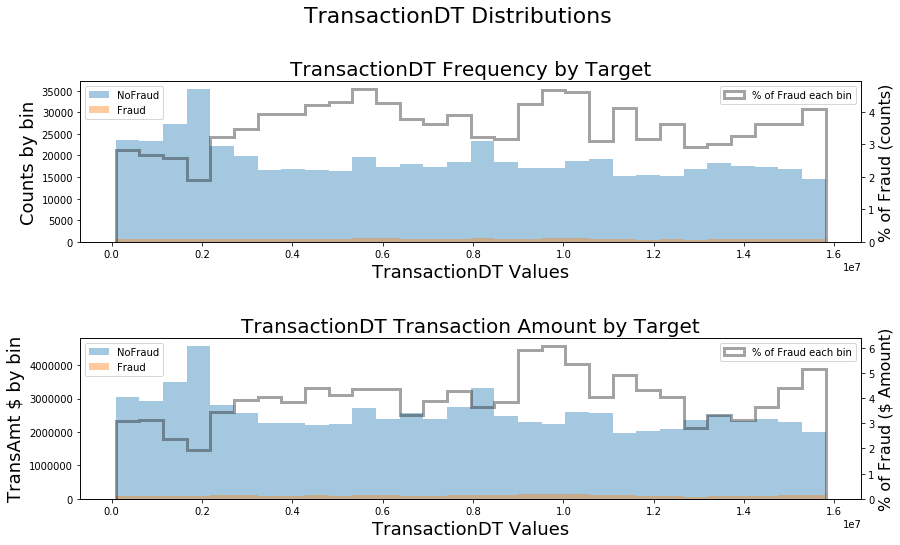

In [2472]:
dist_plot(df, 'TransactionDT')

- % of Fraud shows somewhat periodic behavior.
- We can dig in more to check if % of Fraud is periodic over hours, days, months

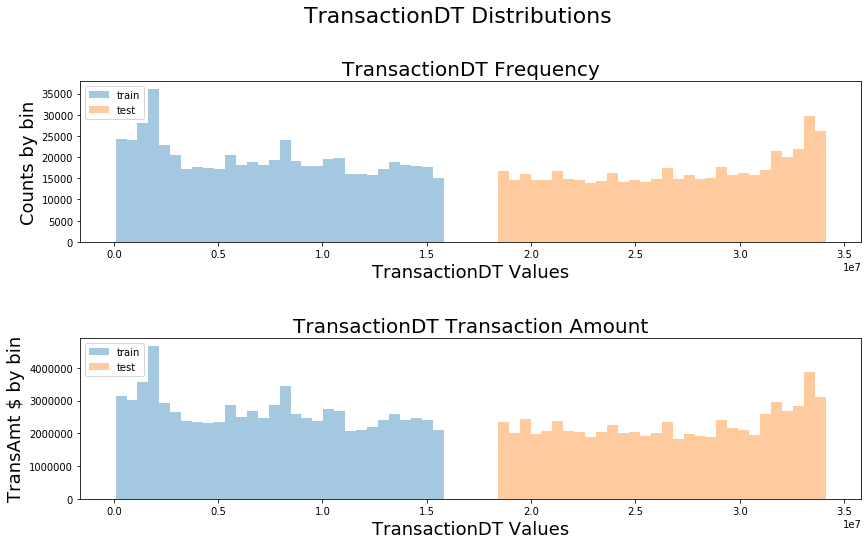

In [2473]:
dist_plot(df, 'TransactionDT',df_test = df_test)

- train and test set are divided by Transaction time. They are apart by about a month

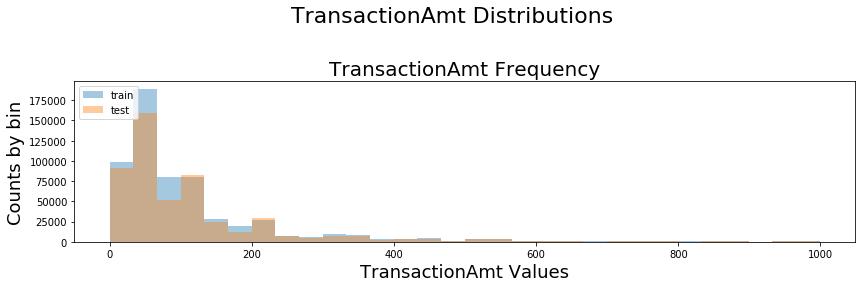

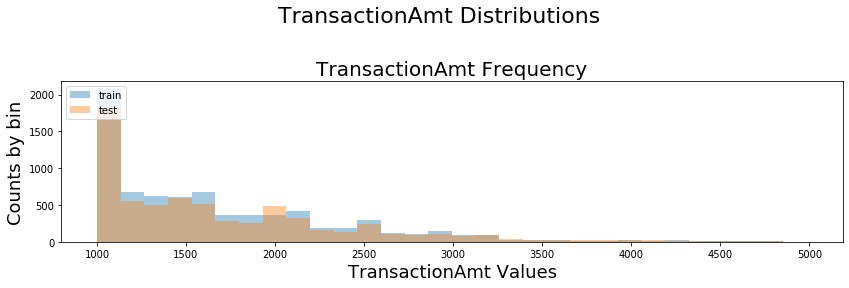

In [2883]:
dist_plot(df[df['TransactionAmt']<1000],'TransactionAmt',df_test = df_test[df_test['TransactionAmt']<1000])
dist_plot(df[(1000<=df['TransactionAmt']) & (df['TransactionAmt']<5000)],'TransactionAmt',\
          df_test = df_test[(1000<=df_test['TransactionAmt']) & (df_test['TransactionAmt']<5000)])

- train has more data but train-TransAmt and test-TransAmt distribution are quite similar

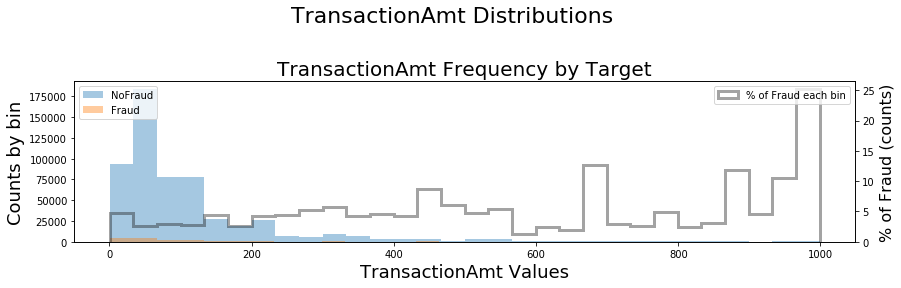

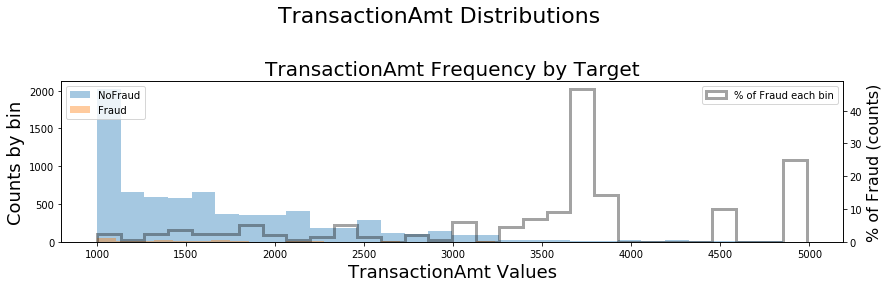

In [2884]:
dist_plot(df[df['TransactionAmt']<1000],'TransactionAmt')
dist_plot(df[(1000<=df['TransactionAmt']) & (df['TransactionAmt']<5000)],'TransactionAmt')
#dist_plot(df[(5000<=df['TransactionAmt']) & (df['TransactionAmt']<10000)],'TransactionAmt')

- High % of Fraud at higher TransAmt.

In [2320]:
list(df.columns)[4:10]

Index(['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5'], dtype='object')

In [2736]:
summary_table(df[list(df.columns)[4:11]])

ProductCD  card1    card2    card3   card4    card5   card6
dtypes     object  int32  float32  float32  object  float32  object
missing         0      0     8933     1565       0     4259    1571
uniques         5  13553      500      114       5      119       4
min           nan   1000      100      100     nan      100     nan
max           nan  18396      600      231     nan      237     nan
top             W   7919      321      150    visa      226   debit
freq       439670  14932    48935   521287  384767   296546  439938

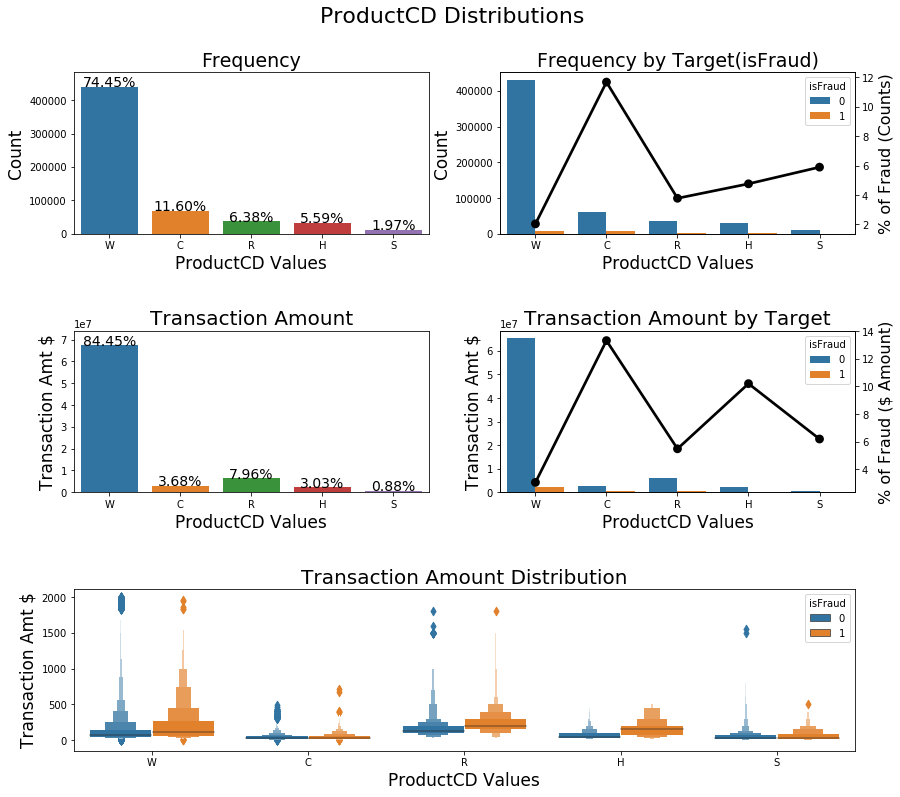

In [2694]:
bar_plot(df,'ProductCD')

- Mostly W.
- % of Fraud high for C
- W, R, H show higher TransAmt in Fraud than Non-Fraud, most noticable for H but H has only a few percents of data. 
- Worth trying (feature)-TransAmt combined feature

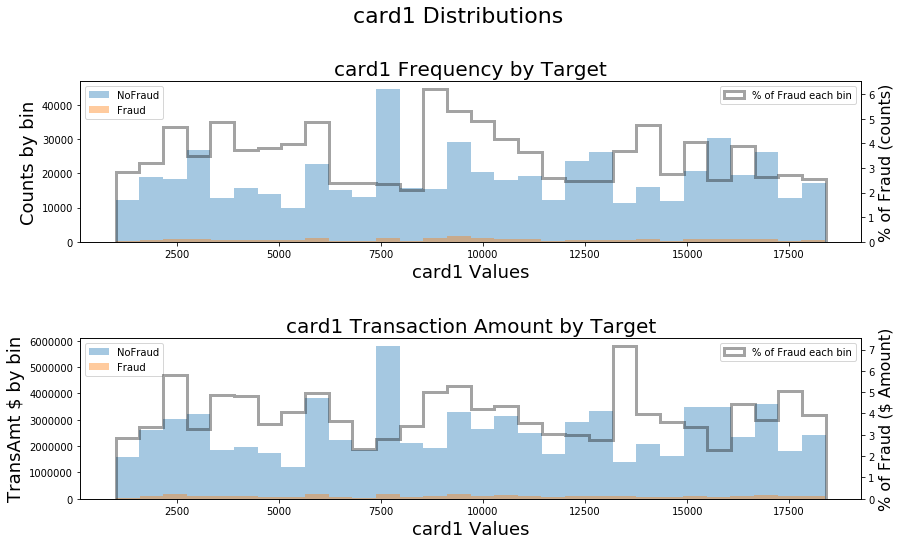

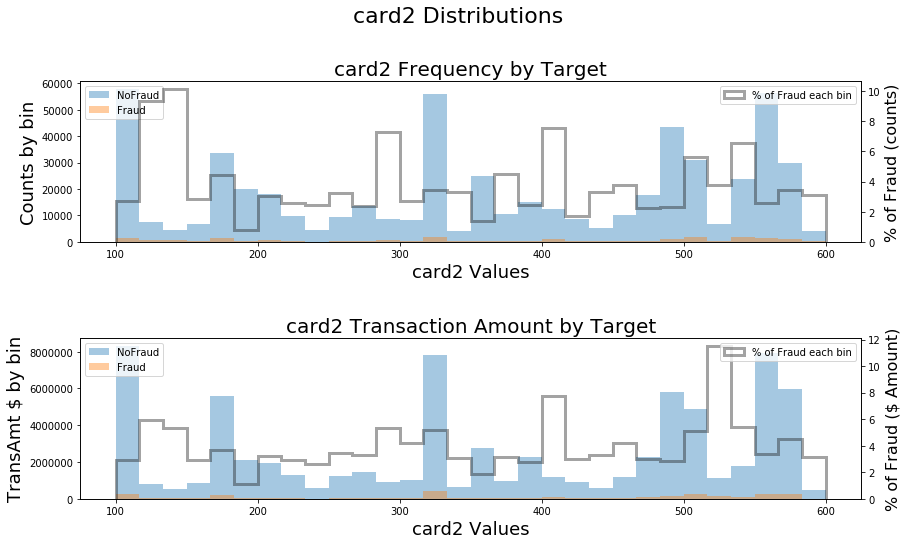

In [2695]:
dist_plot(df, 'card1')
dist_plot(df, 'card2')

- card1 % of Fraud varies much over values
- card1 % of Fraud TransAmt shows some variation from % Fraud Counts. 
- Worth trying (feature)-TransAmt combined feature
- card2 % of Fraud varies mostly in bins with small number of data
- card2 % of Fraud TransAmt also consistent with % of Fraud Counts in bins with large number of data.

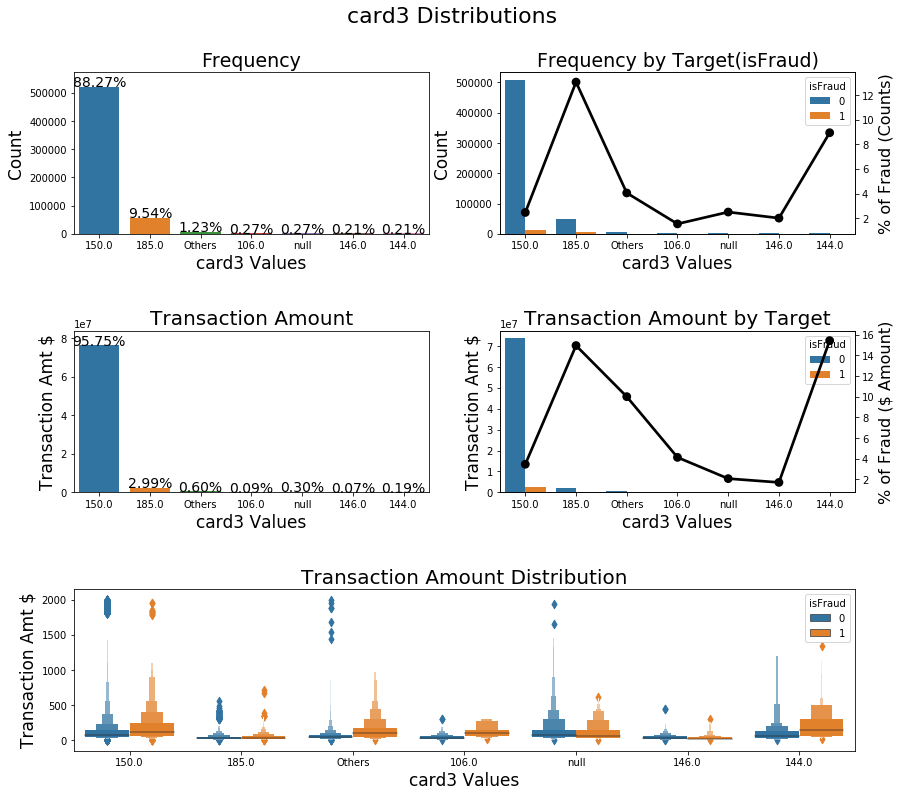

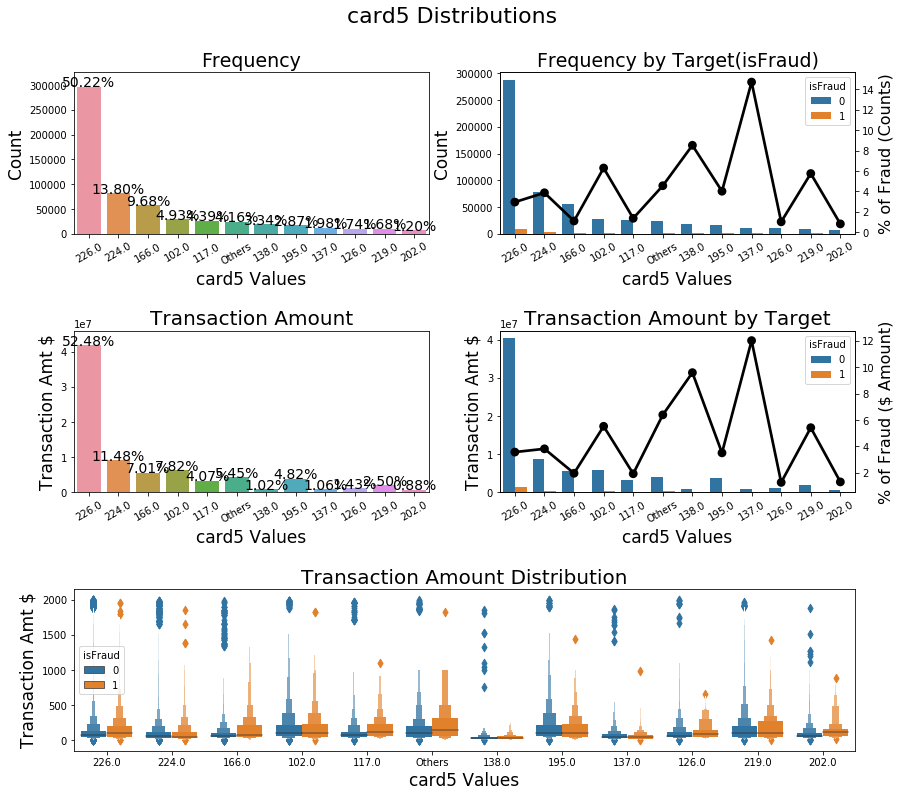

In [2800]:
bar_plot(df, 'card3',others_threshold=1000)
bar_plot(df, 'card5', xtick_rotate=True)

- card3 most data are 150 with a little higher mean-TransAmt in Fraud.
- card3 the next common value 185 has much higher %Fraud in Amt than %Fraud in Counts. 
- Worth trying (feature)-TransAmt combined feature
- card5 more than half are 226. No noticable difference between Fraud and NoFraud

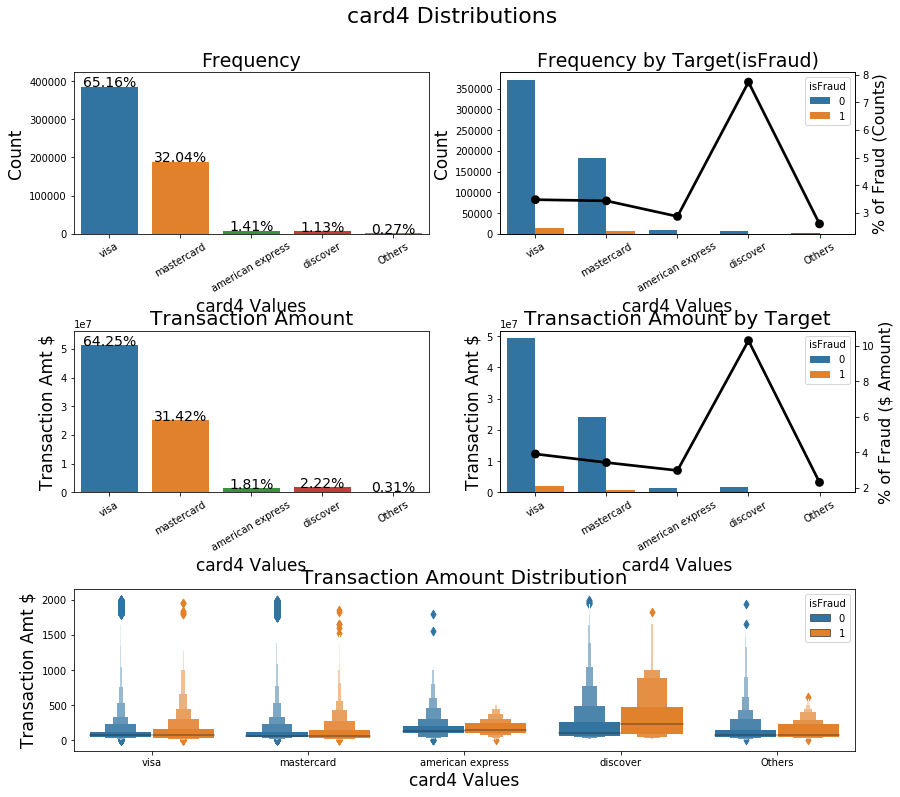

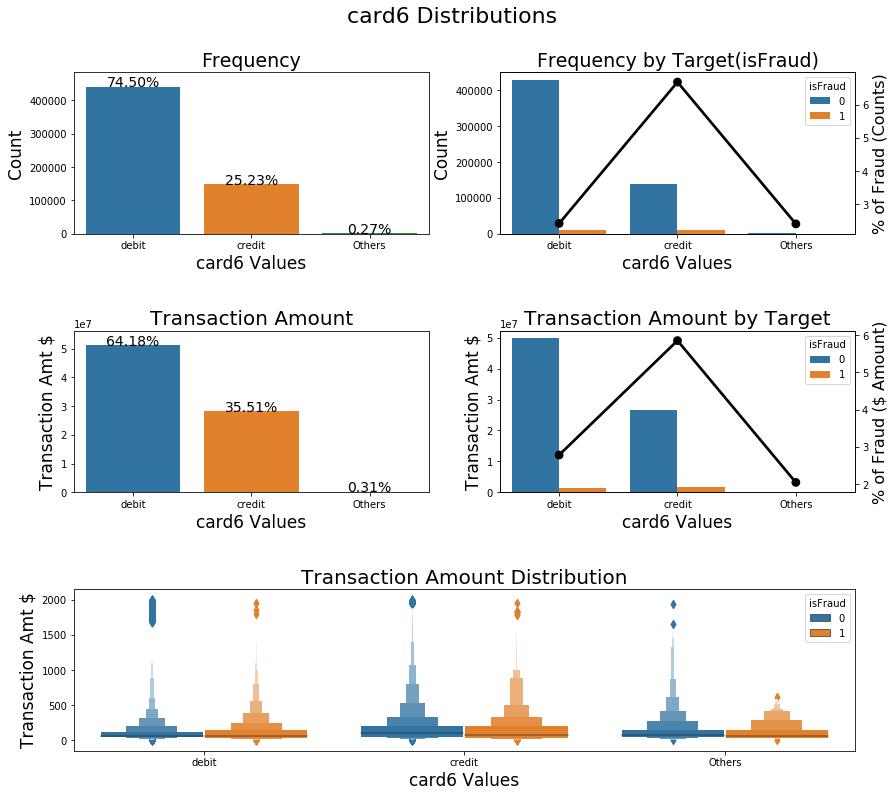

In [2801]:
bar_plot(df, 'card4', xtick_rotate=True)
bar_plot(df, 'card6')

- card4 visa and mastercard consist of ~97% of data.
- card4 discover (although only 1.13% of data) shows big disparity in Fraud-TransAmt and NoFraud-TransAmt.
- card4_discover-TransAmt would be good feature.
- card6 credit has in average lower TransAmt in Fraud.
- card6 debit has higher %Fraud in TransAmt than Counts.

In [2738]:
list(df.columns)[11:17]

['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']

In [2759]:
summary_table(df[list(df.columns)[11:17]])

addr1    addr2    dist1    dist2 P_emaildomain R_emaildomain
dtypes   float32  float32  float32  float32        object        object
missing    65706    65706   352271   552913         94456        453249
uniques      332       74     2412     1699            59            60
min          100       10        0        0           nan           nan
max          540      102    10288    11624           nan           nan
top          299       87        0        7     gmail.com     gmail.com
freq       46335   520481    19824     5687        228355         57147

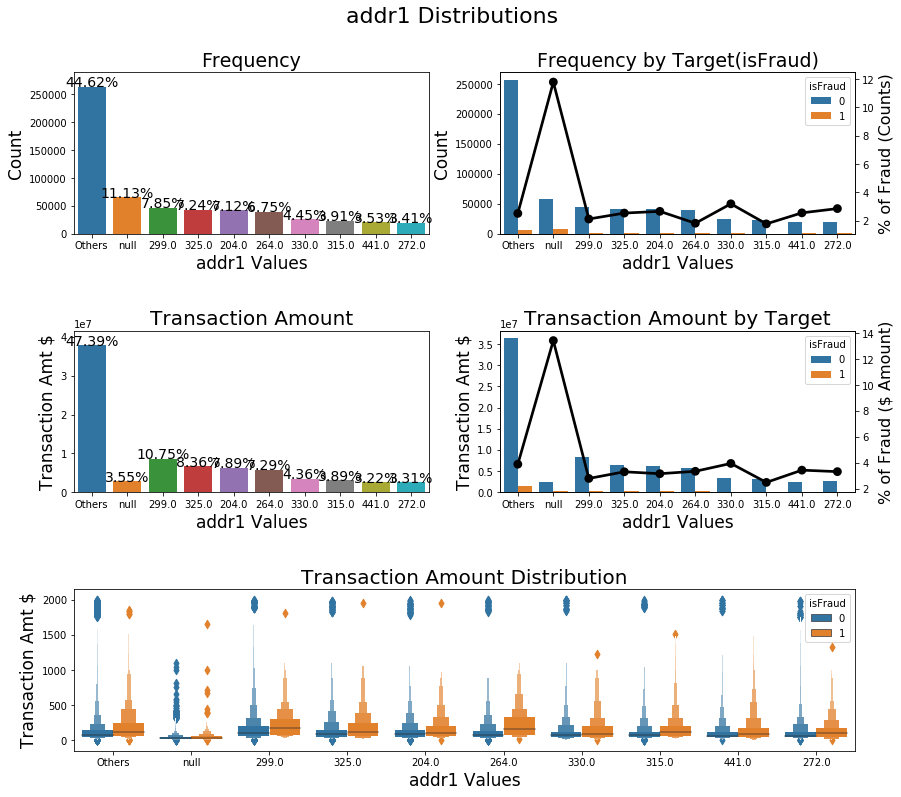

In [2785]:
bar_plot(df, 'addr1', others_threshold=20000)

- 299 and 264 has higher TransAmt in Fraud
- null data has comparably higher %Fraud in TransAmt than %Fraud in Counts
- Worth trying (feature)-TransAmt combined feature

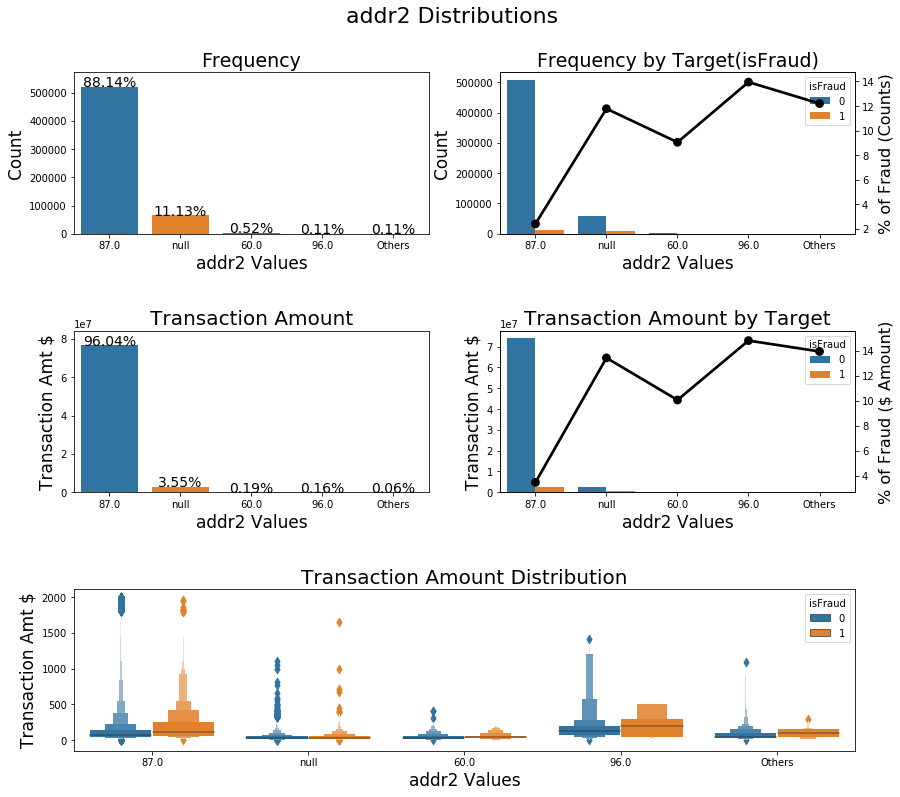

In [2778]:
bar_plot(df, 'addr2', others_threshold=500)

- <1% data other than 87 and null
- 87 shows slightly higher TransAmt in average in Fraud than NoFraud
- Worth trying (feature)-TransAmt combined feature

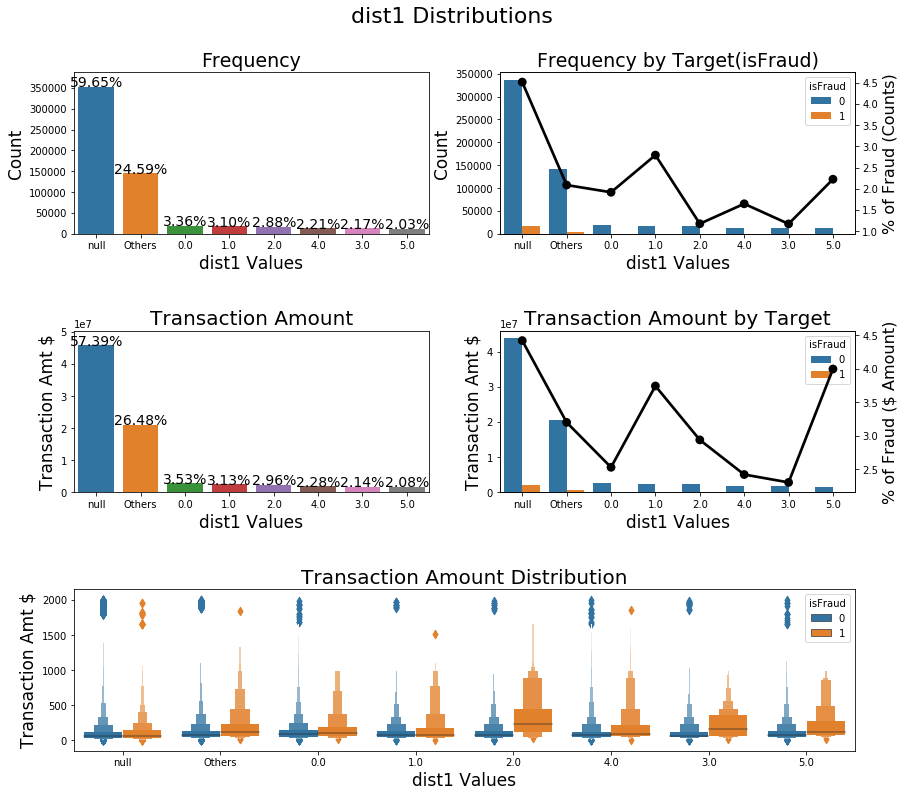

In [2787]:
bar_plot(df,'dist1', others_threshold=10000)

- More than half are null.
- 2, 3, 5 show much higher TransAmt in avg in Fraud than in NoFraud.
- Worth trying (feature)-TransAmt combined feature

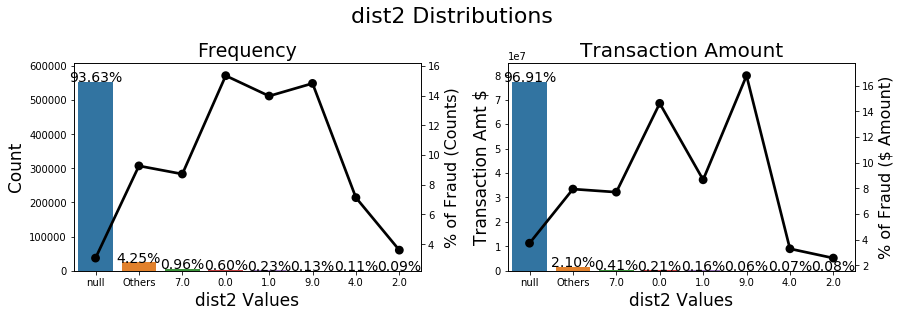

In [2849]:
bar_plot(df,'dist2',others_threshold=500, reduced=True)

- Mostly null

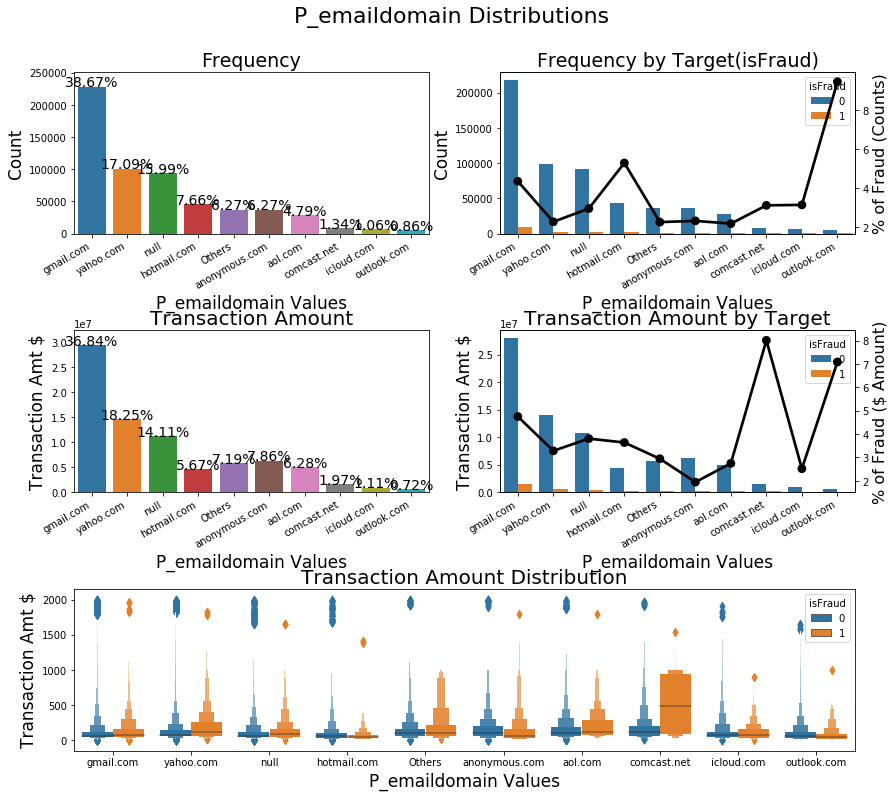

In [2804]:
bar_plot(df, 'P_emaildomain', xtick_rotate=True)

- comcast.net show significant disparity between Fraud-TransAmt and NoFraud-TransAmt
- yahoo.com and null show higher Fraud-TransAmt than NoFraud-TransAmt too
- hotmail.com and anomymous.com, on the other hand, show lower Fraud-TransAmt than NoFraud-TransAmt
- Worth trying (feature)-TransAmt combined feature

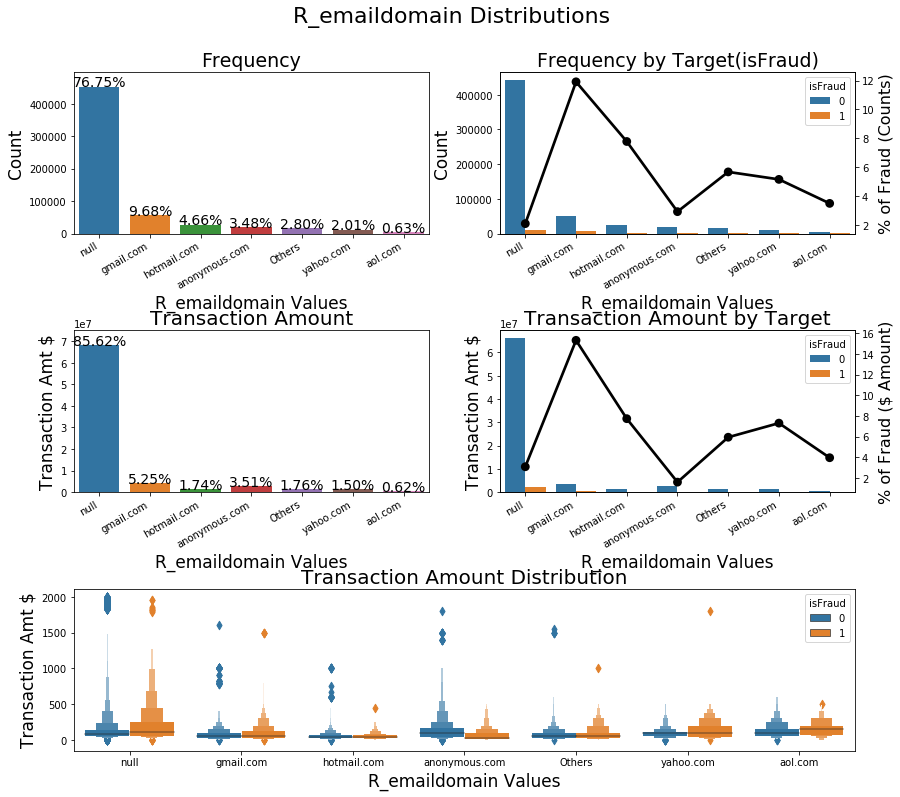

In [2829]:
bar_plot(df, 'R_emaildomain', others_threshold=3000, xtick_rotate=True)

- null has higher Fraud-TransAmt than NoFraud-TransAmt
- anonymous.com has lower Fraud-TransAmt then NoFraud-TransAmt

In [2856]:
summary_table(df[list(df.columns)[17:31]])

C1       C2       C3       C4       C5       C6       C7  \
dtypes   float32  float32  float32  float32  float32  float32  float32   
missing        0        0        0        0        0        0        0   
uniques     1495     1167       27     1223      319     1291     1069   
min            0        0        0        0        0        0        0   
max         4684     5692       26     2252      349     2252     2256   
top            1        1        0        0        0        1        0   
freq      316791   316261   588111   451883   372435   341552   523142   

              C8       C9      C10      C11      C12      C13      C14  
dtypes   float32  float32  float32  float32  float32  float32  float32  
missing        0        0        0        0        0        0        0  
uniques     1130      205     1122     1343     1066     1464     1108  
min            0        0        0        0        0        0        0  
max         3332      210     3256     3188     3188     2918     1429  
top            0        1        0        1        0        1        1  
freq      447667   228938   453442   389692   489199   199337   320189

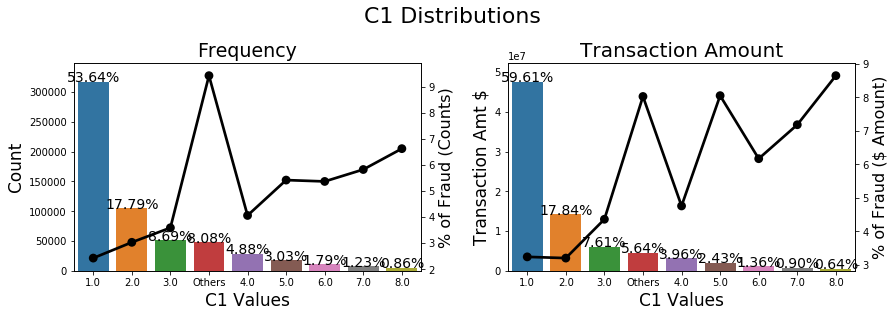

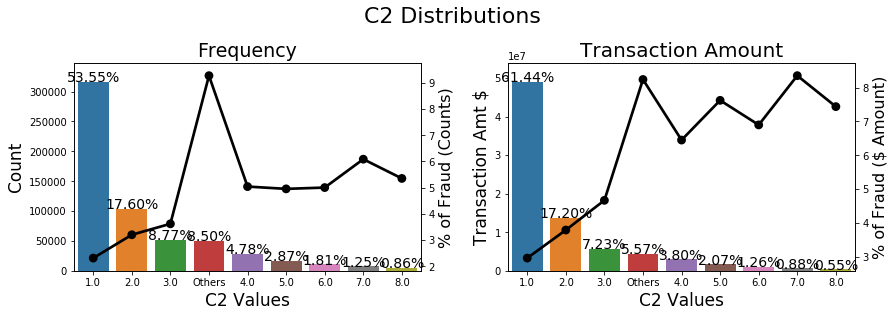

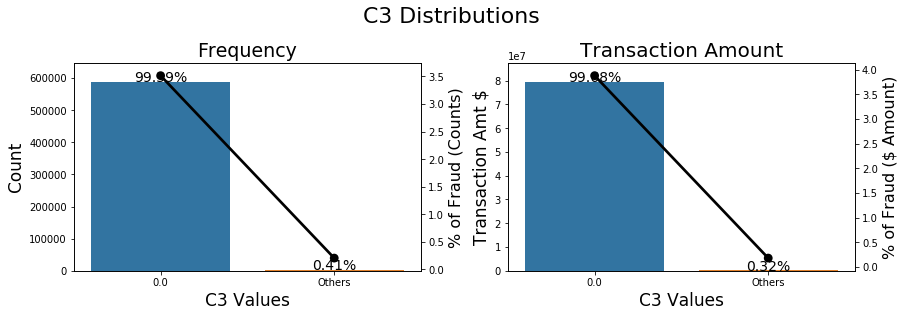

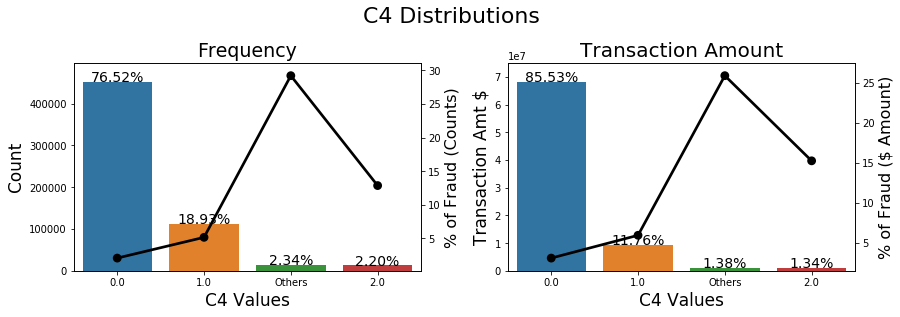

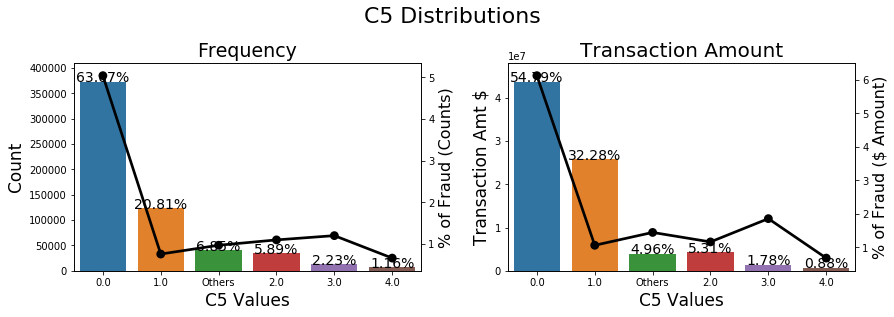

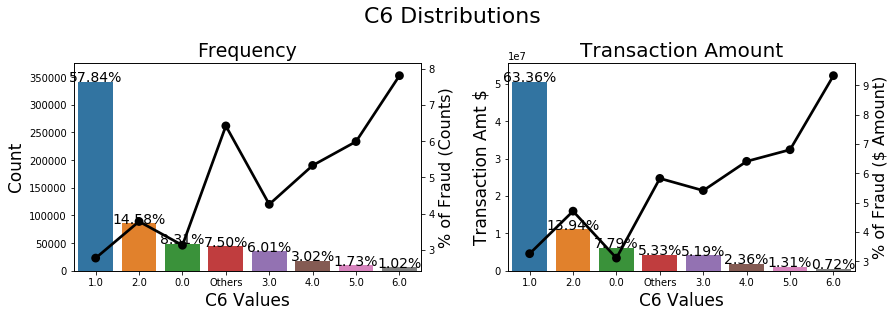

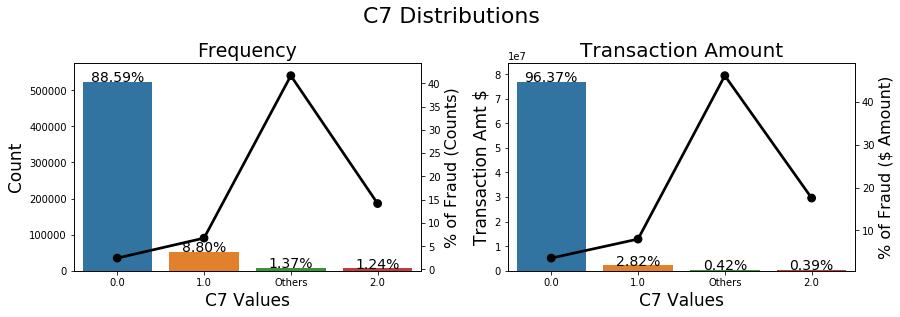

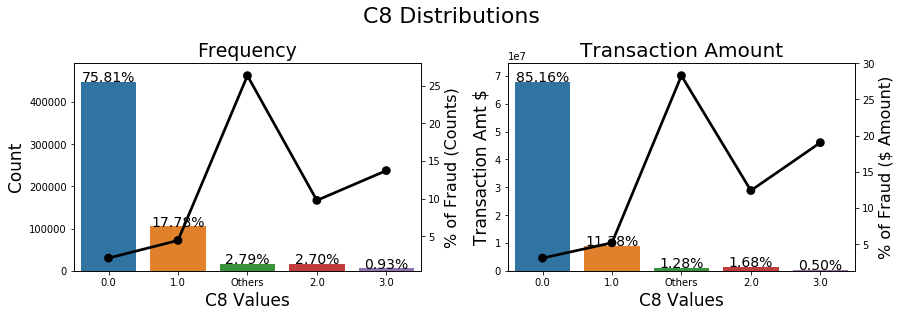

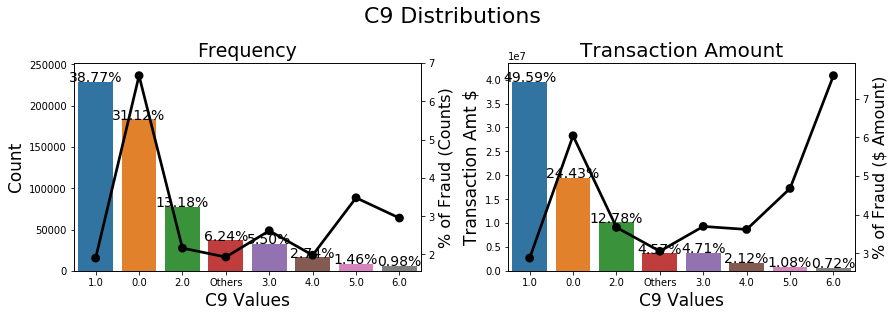

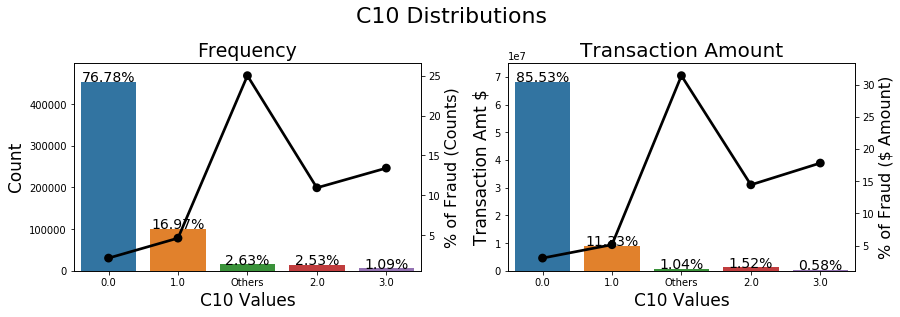

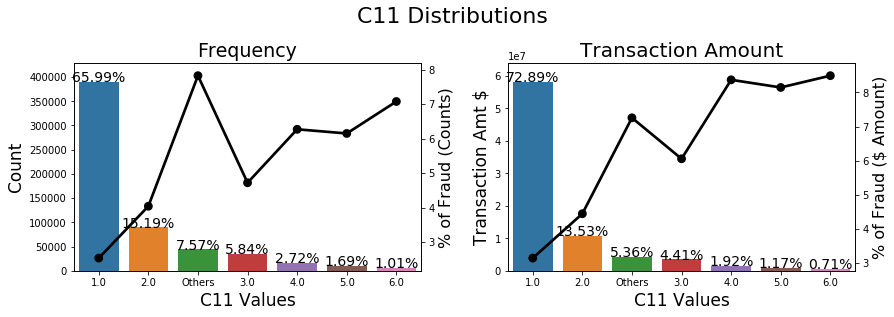

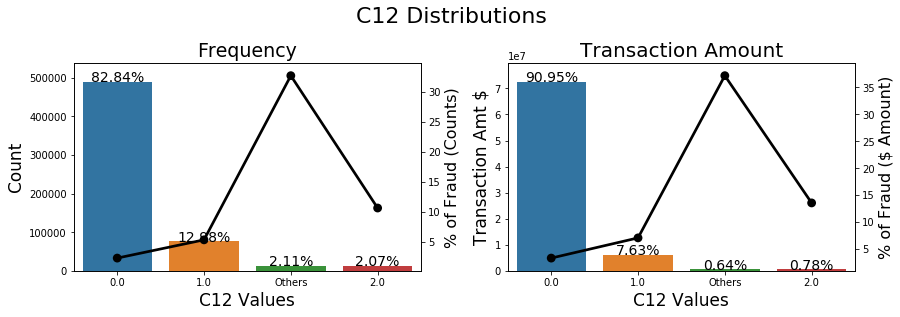

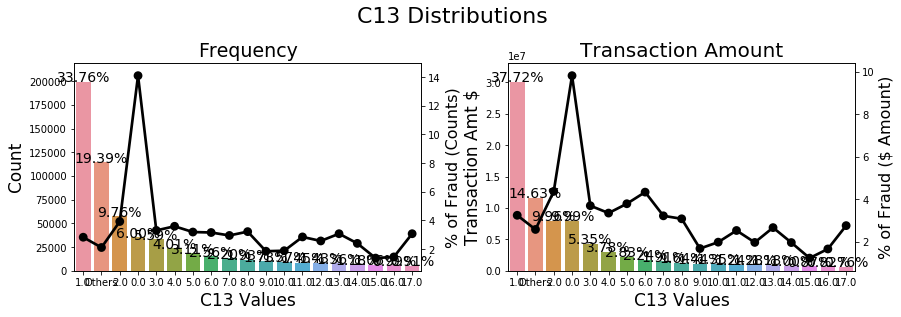

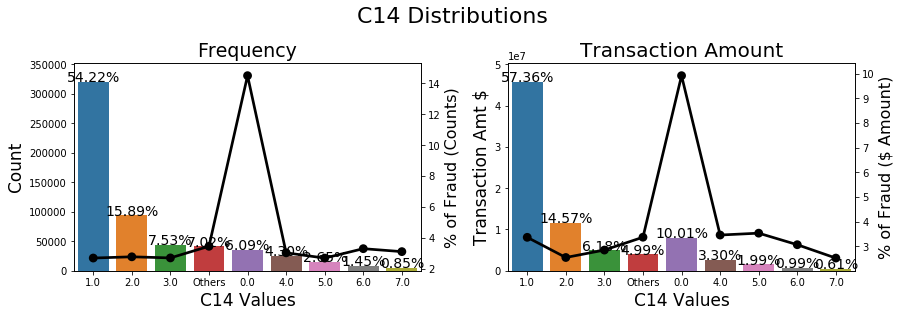

In [2862]:
for col in list(df.columns)[17:31]:
    bar_plot(df,col, others_threshold=5000 ,reduced=True)

- C1 5 (3% of total) has significantly higher %Fraud in TransAmt than %Fraud in Counts
- C1 1 (54% of total) 7, 8 (2% tally) have higher %Fraud in TransAmt than %Fraud in Counts
- C2 generally show higher Fraud-TransAmt than NoFraud-TransAmt
- C3 most data are 0 (>99.5%), nothing to tell
- C4 slight difference between %Fraud in Counts and %Fraud in TransAmt
- C5 1, 3 show higher %Fraud in TransAmt than %Fraud in Counts
- C6 no noticable difference except values with small number of data
- C7 no noticable difference but 0 has a little more Fraud-TransAmt than NoFraud-TransAmt without outliers
- C8 0, 2, 3 have slightly higher Fraud-TransAmt than NoFraud-TransAmt
- C9 noticable difference between %Fraud in Counts and %Fraud in TransAmt
- C10 no noticable difference but 0 has a little more Fraud-TransAmt than NoFraud-TransAmt without outliers
- C11 slight difference between %Fraud in Counts and %Fraud in TransAmt
- C12 0 has a little more Fraud-TransAmt than NoFraud-TransAmt without outliers
- C13 can see slight differences
- C14 0, 1, 7 have noticable differences b/w %Fraud in TransAmt and %Fraud in Counts

In [2939]:
summary_table(df[list(df.columns)[31:46]])

D1       D2       D3       D4       D5       D6       D7  \
dtypes   float32  float32  float32  float32  float32  float32  float32   
missing     1269   280797   262878   168922   309841   517353   551623   
uniques      641      641      649      808      688      829      597   
min            0        0        0     -122        0      -83        0   
max          640      640      819      869      819      873      843   
top            0        0        0        0        0        0        0   
freq      280130    15124    73094   166571    65377    45782    21135   

               D8        D9      D10      D11      D12      D13      D14  \
dtypes    float32   float32  float32  float32  float32  float32  float32   
missing    515614    515614    76022   279287   525823   528588   528353   
uniques      5367        24      818      676      635      577      802   
min             0         0        0      -53      -83        0     -193   
max          1708  0.958496      876      670      648      847      878   
top      0.791504  0.791504        0        0        0        0        0   
freq         1351      5388   221930   112281    42756    48840    45266   

             D15  
dtypes   float32  
missing    89113  
uniques      859  
min          -83  
max          879  
top            0  
freq      174246

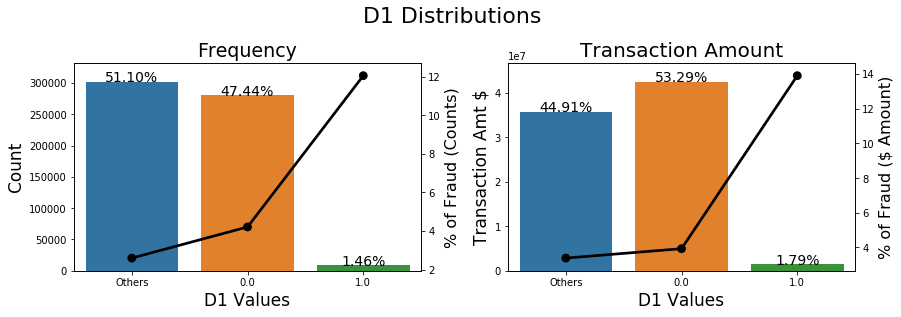

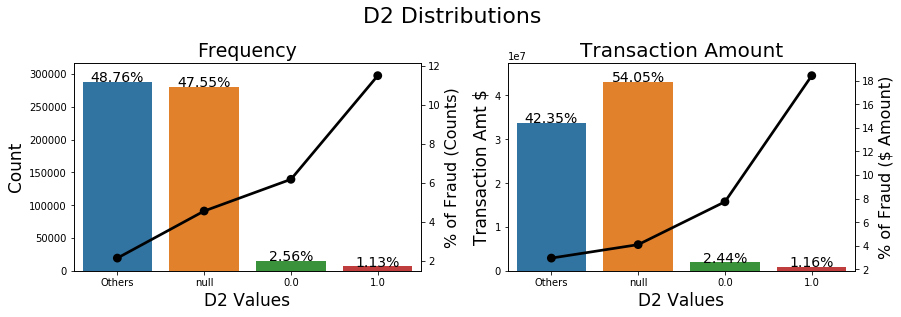

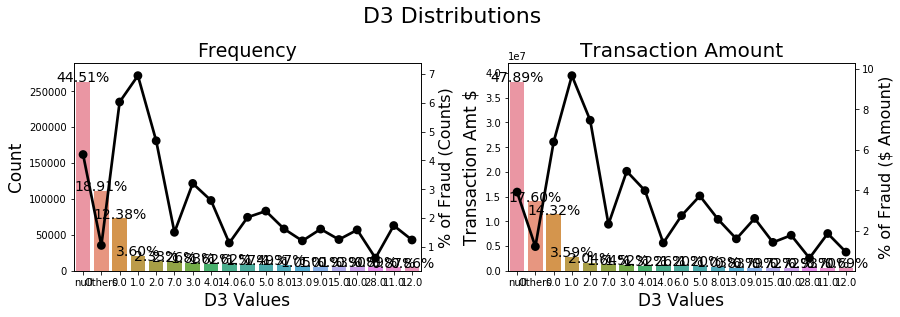

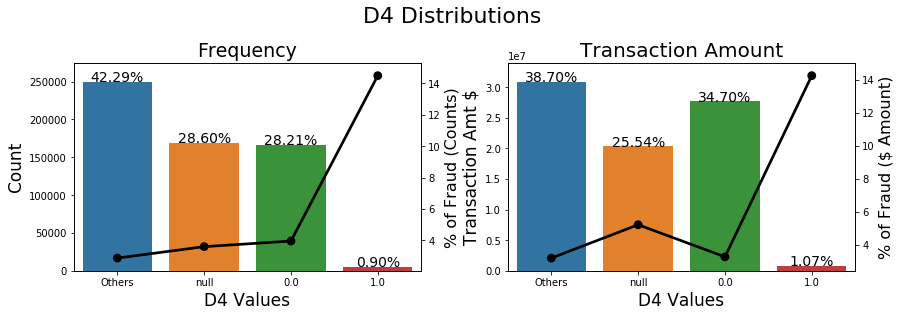

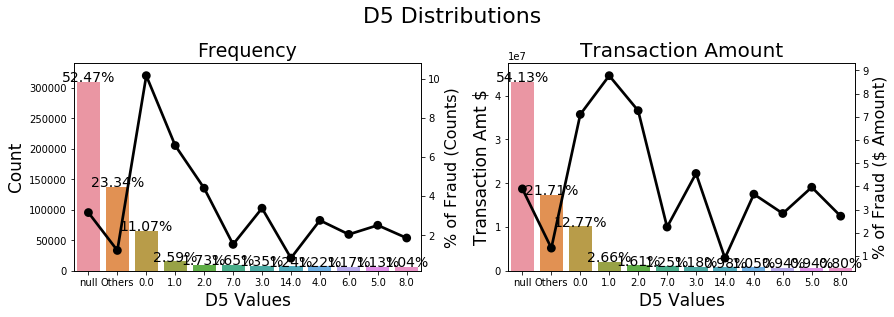

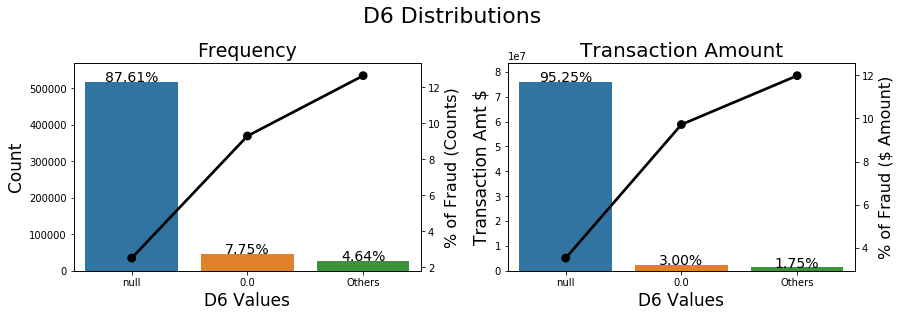

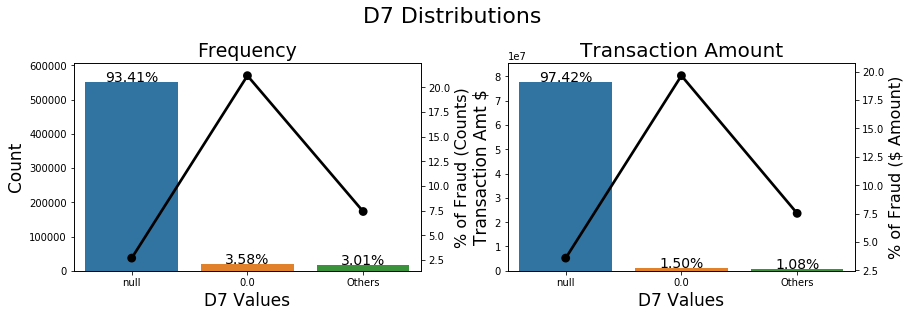

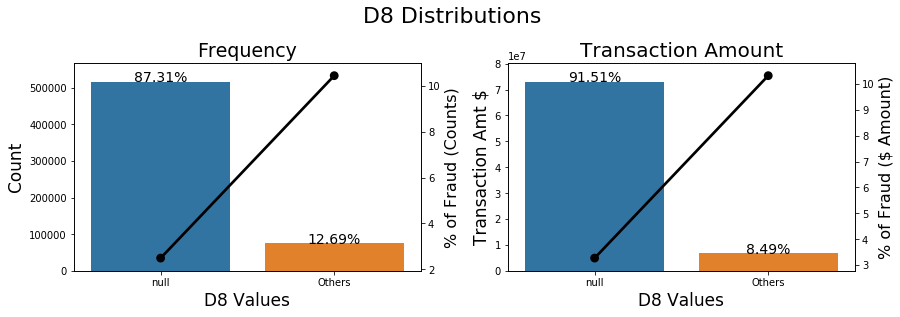

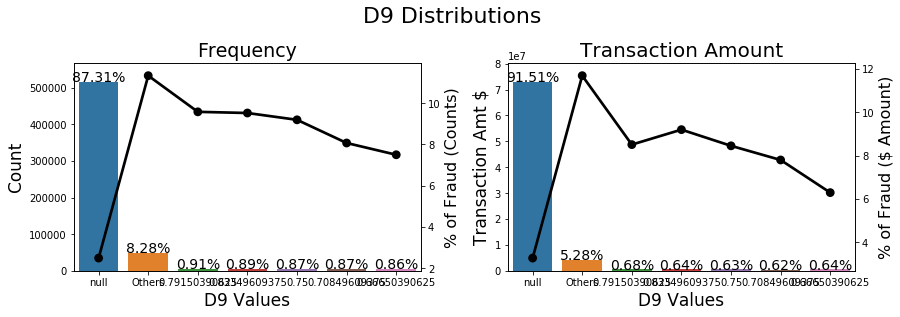

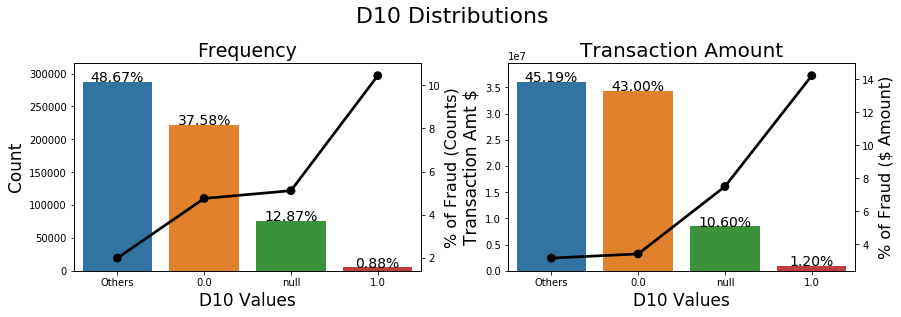

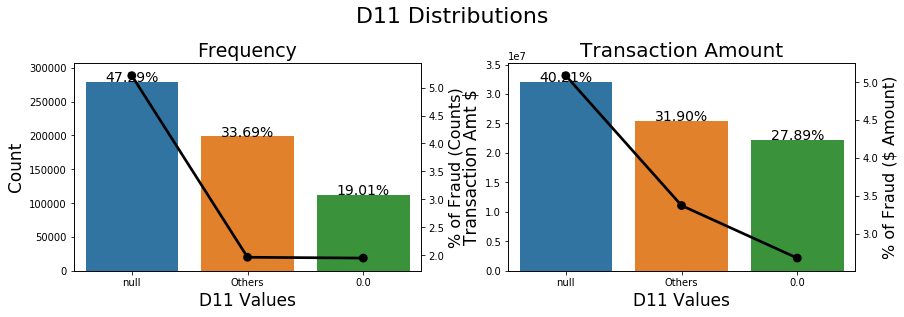

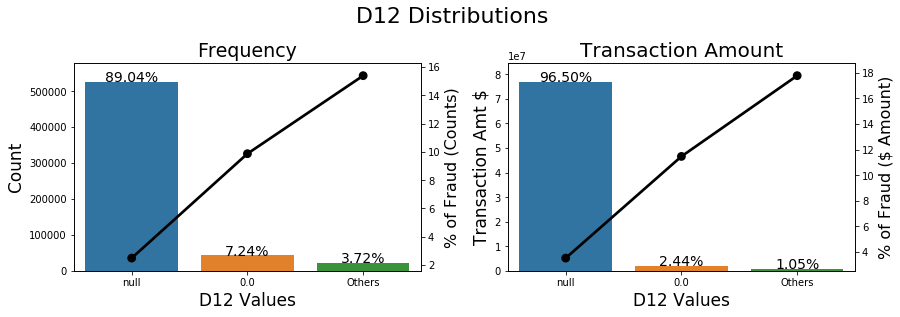

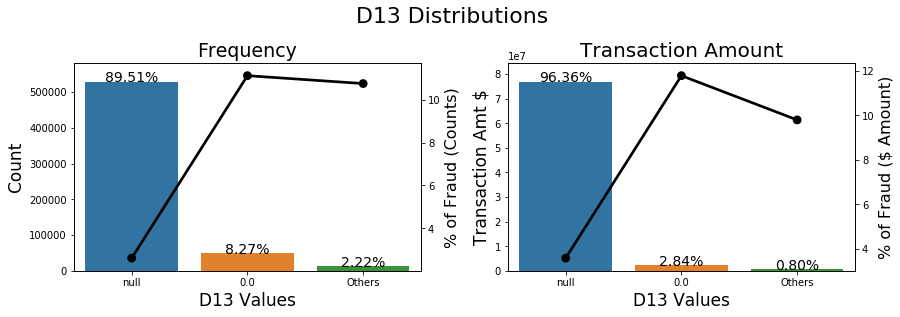

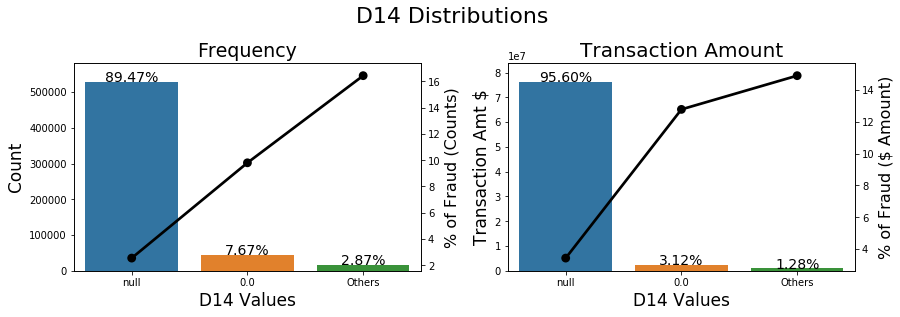

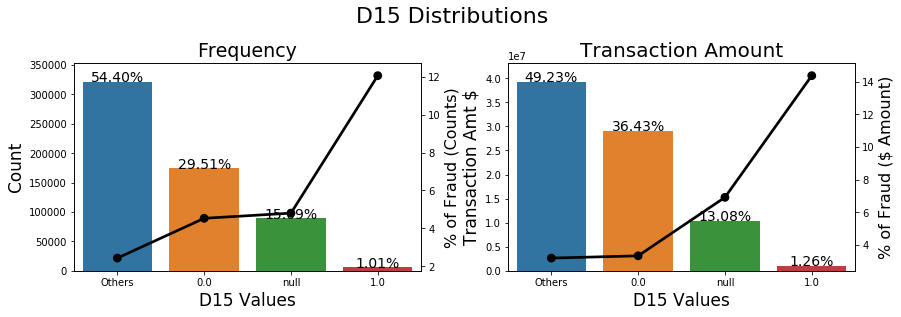

In [2940]:
for col in list(df.columns)[31:46]:
    bar_plot(df,col, others_threshold=5000 ,reduced=True)

- So many null data
- D1 D3 D5 D9 D10 D11 D13 D14 D15 show differences b/w %Fraud in TransAmt and %Fraud in Counts in values other than null data

In [2944]:
summary_table(df[list(df.columns)[46:55]])

M1      M2      M3      M4      M5      M6      M7      M8  \
dtypes   object  object  object  object  object  object  object  object   
missing  271100  271100  271100  281444  350482  169360  346265  346252   
uniques       2       2       2       3       2       2       2       2   
min         nan     nan     nan     nan     nan     nan     nan     nan   
max         nan     nan     nan     nan     nan     nan     nan     nan   
top           T       T       T      M0       F       F       F       F   
freq     319415  285468  251731  196405  132491  227856  211374  155251   

             M9  
dtypes   object  
missing  346252  
uniques       2  
min         nan  
max         nan  
top           T  
freq     205656

posx and posy should be finite values
posx and posy should be finite values


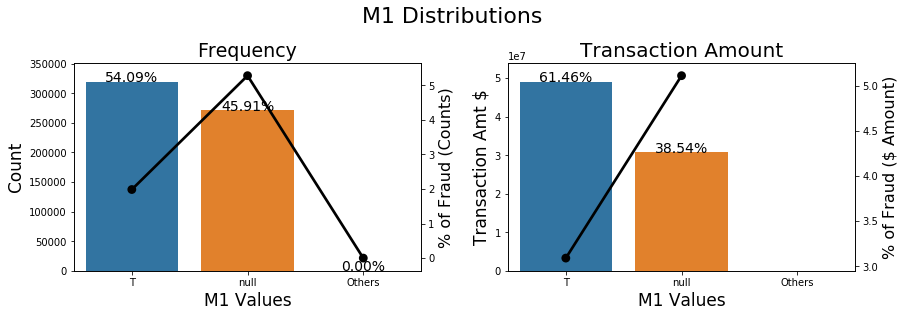

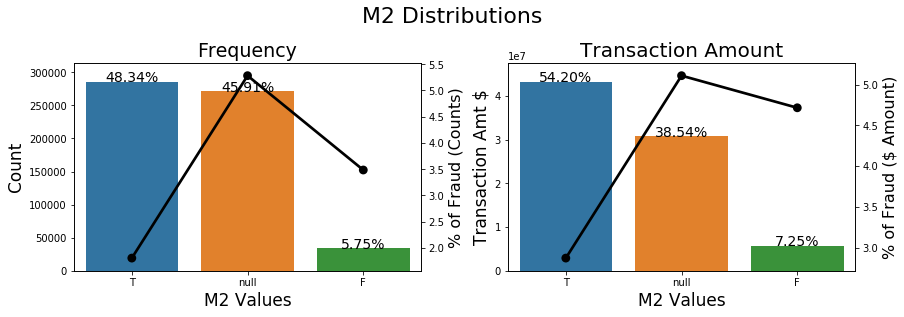

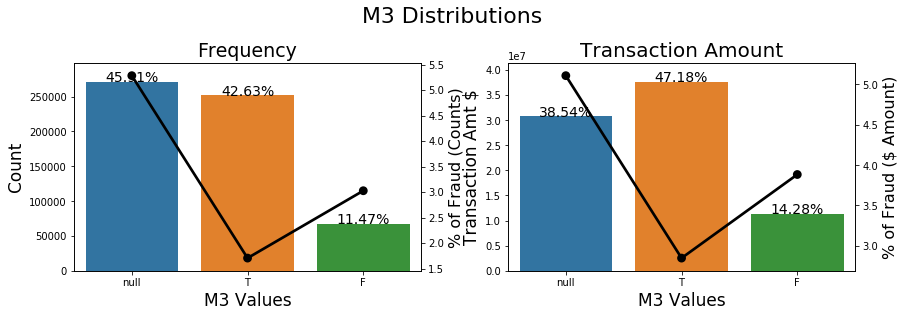

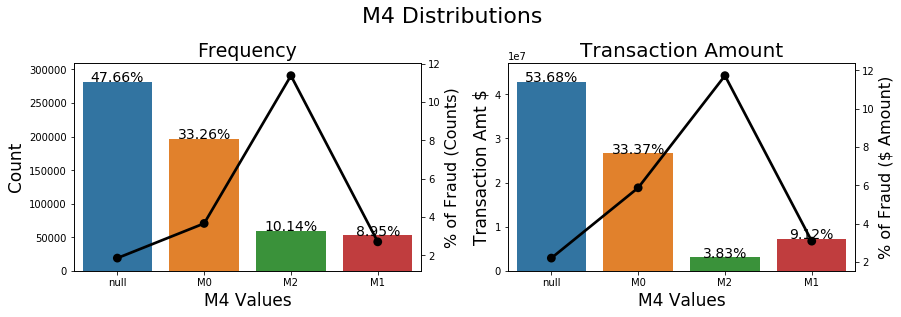

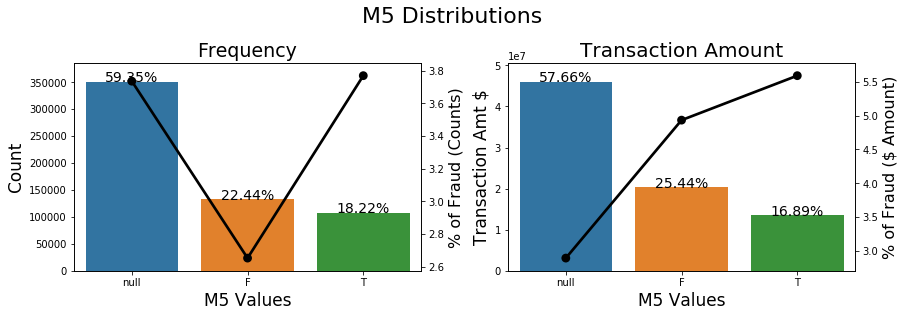

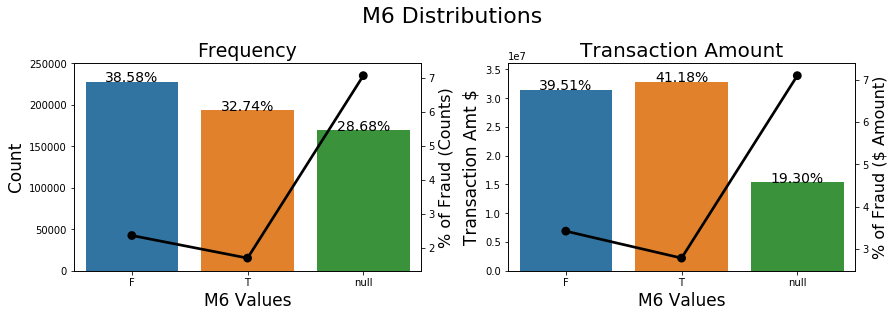

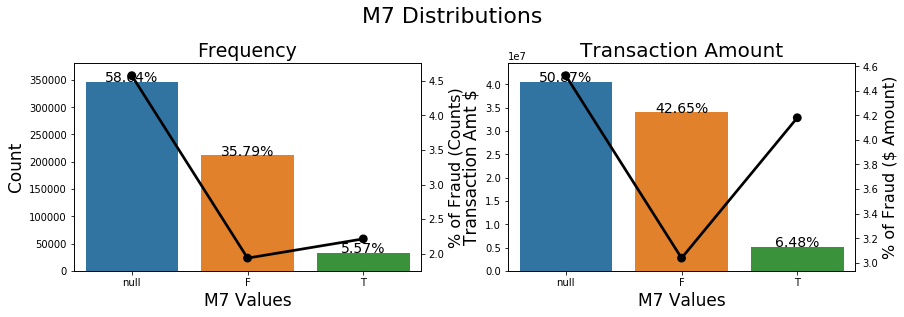

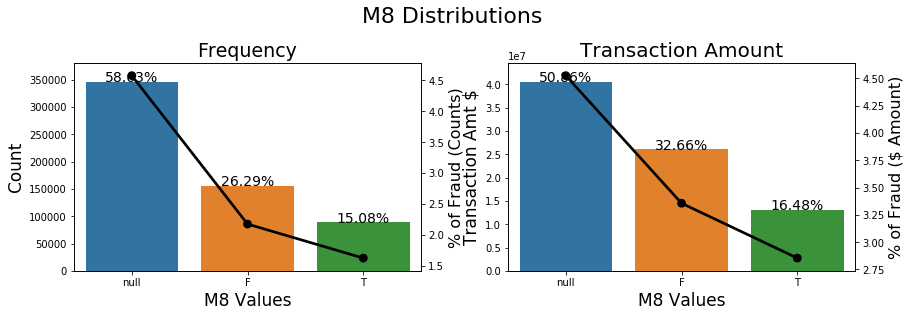

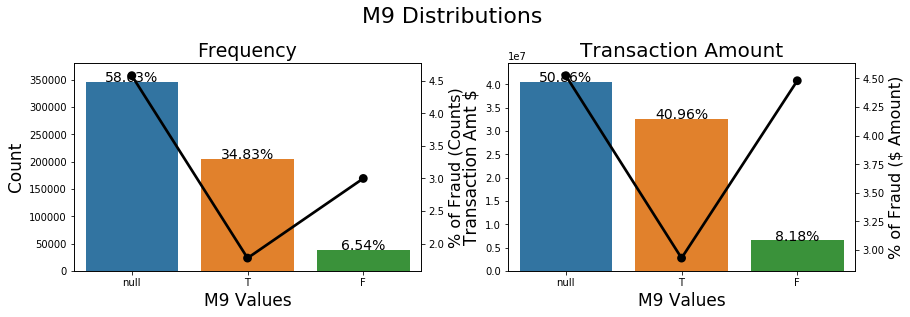

In [2945]:
for col in list(df.columns)[46:55]:
    bar_plot(df,col, others_threshold=5000 ,reduced=True)

- Many null data but few feature values -> easy to analyze
- show some disparity b/w %Fraud in TransAmt and %Fraud in Counts

In [2955]:
summary_table(df[list(df.columns)[55:394]])

V1       V2       V3       V4       V5       V6       V7  \
dtypes   float32  float32  float32  float32  float32  float32  float32   
missing   279287   279287   279287   279287   279287   279287   279287   
uniques        2        9       10        7        7       10       10   
min            0        0        0        0        0        0        0   
max            1        8        9        6        6        9        9   
top            1        1        1        1        1        1        1   
freq      311236   298894   290583   246500   242883   298627   291485   

              V8       V9      V10  ...     V330     V331     V332     V333  \
dtypes   float32  float32  float32  ...  float32  float32  float32  float32   
missing   279287   279287   279287  ...   508189   508189   508189   508189   
uniques        9        9        5  ...       56     1758     2453     1971   
min            0        0        0  ...        0        0        0        0   
max            8        8        4  ...       55   160000   160000   160000   
top            1        1        0  ...        0        0        0        0   
freq      303466   299625   170281  ...    72799    65970    60806    62945   

            V334     V335     V336     V337     V338     V339  
dtypes   float32  float32  float32  float32  float32  float32  
missing   508189   508189   508189   508189   508189   508189  
uniques      143      669      355      254      380      334  
min            0        0        0        0        0        0  
max        55136    55136    55136   104060   104060   104060  
top            0        0        0        0        0        0  
freq       78588    72668    75098    73464    72114    72799  

[7 rows x 339 columns]

- V1 - V339, 339 columns

In [2961]:
summary_table(df[list(df.columns)[394:432]])

id_01    id_02    id_03    id_04    id_05    id_06    id_07  \
dtypes   float32  float32  float32  float32  float32  float32  float32   
missing   446307   449668   524216   524216   453675   453675   585385   
uniques       77   115655       24       15       93      101       84   
min         -100        1      -13      -28      -72     -100      -46   
max            0   999595       10        0       52        0       61   
top           -5     1102        0        0        0        0        0   
freq       82170       11    63903    65739    92743    91325      409   

           id_08    id_09    id_10  ...   id_29       id_30        id_31  \
dtypes   float32  float32  float32  ...  object      object       object   
missing   585385   515614   515614  ...  449562      512975       450258   
uniques       94       46       62  ...       2          75          130   
min         -100      -36     -100  ...     nan         nan          nan   
max            0       25        0  ...     nan         nan          nan   
top         -100        0        0  ...   Found  Windows 10  chrome 63.0   
freq         500    70378    72879  ...   74926       21155        22000   

           id_32      id_33           id_34   id_35   id_36   id_37   id_38  
dtypes   float32     object          object  object  object  object  object  
missing   512954     517251          512735  449555  449555  449555  449555  
uniques        4        260               4       2       2       2       2  
min            0        nan             nan     nan     nan     nan     nan  
max           32        nan             nan     nan     nan     nan     nan  
top           24  1920x1080  match_status:2       T       F       T       F  
freq       53071      16874           60011   77814  134066  110452   73922  

[7 rows x 38 columns]

- id_01 - id_38, 38 columns

In [2959]:
summary_table(df[list(df.columns)[432:]])

DeviceType DeviceInfo
dtypes      object     object
missing     449730     471874
uniques          2       1786
min            nan        nan
max            nan        nan
top        desktop    Windows
freq         85165      47722

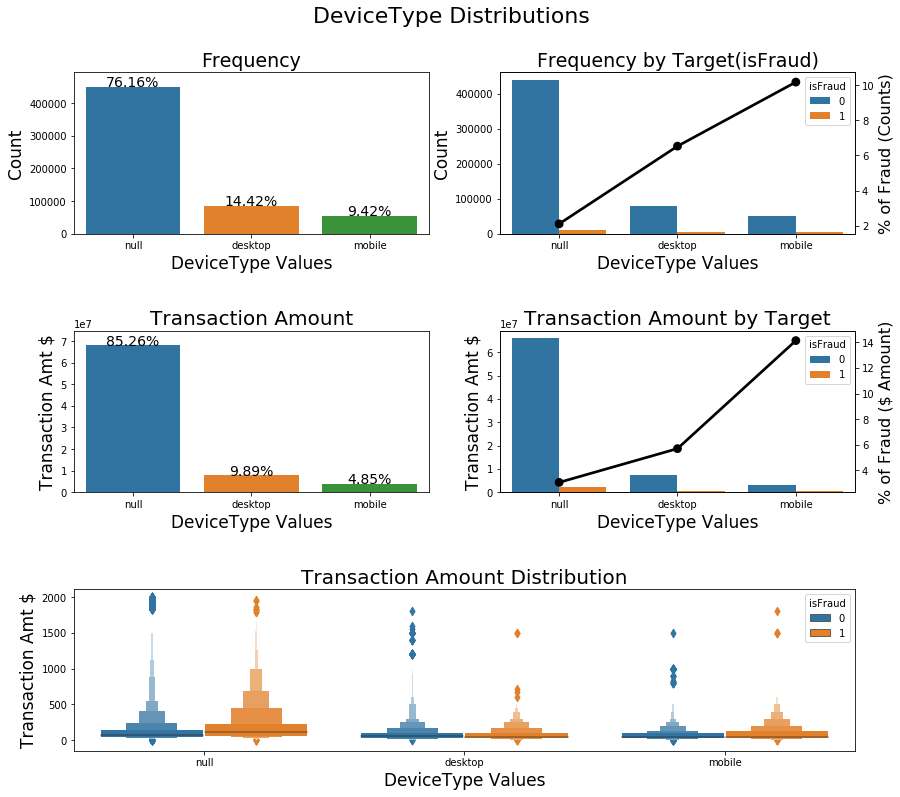

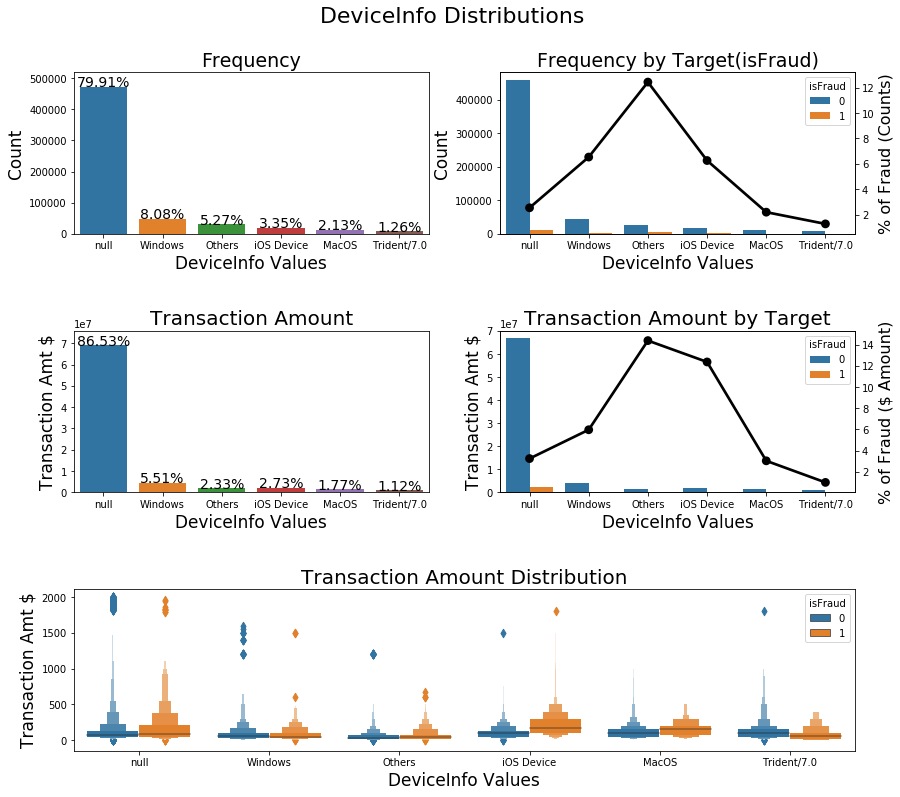

In [2965]:
bar_plot(df,'DeviceType')
bar_plot(df,'DeviceInfo')

- DeviceType desktop shows lower %Fraud in TransAmt than %Fraud in Counts
- DeviceType mobile shows higher %Fraud in TransAmt than %Fraud in Counts
- DeviceInfo iOS Device shows significantly higher %Fraud in TransAmt than %Fraud in Counts